In [18]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/'  #change dir to your project folder

import numpy as np
X_train = np.load('gdrive/My Drive/dataset/acc+gyr/trainX.npy')
y_train = np.load('gdrive/My Drive/dataset1/acc+gyr/trainy.npy')
X_test = np.load('gdrive/My Drive/dataset1/acc+gyr/testX.npy')
y_test = np.load('gdrive/My Drive/dataset1/acc+gyr/testy.npy')
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Mounted at /content/drive
Mounted at /content/gdrive
(33104, 128, 6) (33104, 118) (3740, 128, 6) (3740, 118)


In [19]:
from numpy import mean
from numpy import std
from numpy import dstack
from numpy import save, load
from pandas import read_csv
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Input ,concatenate
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Conv1D, concatenate,GlobalMaxPooling1D,TimeDistributed, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import concatenate
from tensorflow.keras import regularizers

In [20]:
from sklearn.model_selection import train_test_split
X_training, X_validation, y_training, y_validation = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
validation_data=(X_validation, y_validation)

In [27]:
LSTM_model= Sequential()
LSTM_model.add(LSTM(512,input_shape=(n_timesteps,n_features),return_sequences=True))
LSTM_model.add(LSTM(256))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(Dense(128, activation='relu'))
LSTM_model.add(Dense(n_outputs, activation='softmax'))
LSTM_model.summary()
LSTM_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks = [keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
LSTM_model.fit(X_training, y_training, epochs=200, verbose=True, validation_data=(X_validation, y_validation), batch_size=128,callbacks=callbacks)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 128, 512)          1062912   
                                                                 
 lstm_12 (LSTM)              (None, 256)               787456    
                                                                 
 dropout_13 (Dropout)        (None, 256)               0         
                                                                 
 dense_18 (Dense)            (None, 128)               32896     
                                                                 
 dense_19 (Dense)            (None, 118)               15222     
                                                                 
Total params: 1,898,486
Trainable params: 1,898,486
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
207/207 [======================

In [28]:
loss, accuracy = LSTM_model.evaluate(X_validation, y_validation, verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = LSTM_model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy: {:.4f}".format(accuracy))

Validation Accuracy:  0.9693
Testing Accuracy: 0.9045


In [29]:
#lstm_output_layer_weights_values = LSTM_model.layers[4].get_weights()    
LSTM_model.trainable = False

CNN_model= Sequential()
CNN_model.add(Conv1D(filters=32, kernel_size=9, strides=2, activation='relu', input_shape=(n_timesteps,n_features)))
CNN_model.add(MaxPooling1D(pool_size=2 ,strides=2))
CNN_model.add(Dropout(0.5))
CNN_model.add(Conv1D(filters=64, kernel_size=3, strides=1, activation='relu'))
CNN_model.add(Conv1D(filters=128, kernel_size=3, strides=1, activation='relu'))
CNN_model.add(MaxPooling1D(pool_size=2 ,strides=2))
CNN_model.add(Dropout(0.5))
CNN_model.add(Conv1D(filters=128, kernel_size=1, strides=1, activation='relu'))
CNN_model.add(Flatten())
CNN_model.add(Dense(n_outputs, activation='relu'))
CNN_model.summary()


inputs = Input(shape=(n_timesteps,n_features))
mergedInput= concatenate([CNN_model(inputs),LSTM_model(inputs)])
out = Dense(n_outputs, activation='softmax')(mergedInput)
model3 = Model(inputs,out)
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model3.layers[0].set_weights(LSTM_model.layers[4].get_weights())
model3.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 60, 32)            1760      
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 30, 32)           0         
 1D)                                                             
                                                                 
 dropout_14 (Dropout)        (None, 30, 32)            0         
                                                                 
 conv1d_17 (Conv1D)          (None, 28, 64)            6208      
                                                                 
 conv1d_18 (Conv1D)          (None, 26, 128)           24704     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 13, 128)          0         
 1D)                                                 

In [30]:
history = model3.fit(X_training, y_training, epochs=200, verbose=True, validation_data=(X_validation, y_validation), batch_size=128,callbacks=callbacks)

Epoch 1/200
207/207 [==============================] - 12s 42ms/step - loss: 2.4559 - accuracy: 0.4206 - val_loss: 0.8304 - val_accuracy: 0.7946
Epoch 2/200
207/207 [==============================] - 8s 37ms/step - loss: 0.7548 - accuracy: 0.8094 - val_loss: 0.5119 - val_accuracy: 0.8740
Epoch 3/200
207/207 [==============================] - 8s 37ms/step - loss: 0.5166 - accuracy: 0.8670 - val_loss: 0.3645 - val_accuracy: 0.9121
Epoch 4/200
207/207 [==============================] - 8s 37ms/step - loss: 0.4046 - accuracy: 0.8948 - val_loss: 0.3082 - val_accuracy: 0.9218
Epoch 5/200
207/207 [==============================] - 8s 37ms/step - loss: 0.3422 - accuracy: 0.9110 - val_loss: 0.2689 - val_accuracy: 0.9369
Epoch 6/200
207/207 [==============================] - 8s 38ms/step - loss: 0.2878 - accuracy: 0.9244 - val_loss: 0.2376 - val_accuracy: 0.9388
Epoch 7/200
207/207 [==============================] - 8s 38ms/step - loss: 0.2476 - accuracy: 0.9355 - val_loss: 0.2120 - val_accuracy

In [31]:
loss, accuracy = model3.evaluate(X_validation, y_validation, verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model3.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy: {:.4f}".format(accuracy))

Validation Accuracy:  0.9719
Testing Accuracy: 0.9136


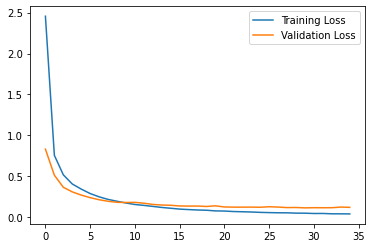

In [32]:
from matplotlib import pyplot as plt
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()